# Pythonで学ぶ有限要素法（自動微分編）
線形等方弾性体に対する有限要素法による自動微分を用いた三次元解析のサンプルコードです．  
YouTubeチャンネル [大学生・技術者のための有限要素法](https://www.youtube.com/@fempython) の動画に対応しています．  
このnotebookには数式と対応するPythonスクリプトしか記載していないため，詳細な解説は対応する動画をご参照ください．

## 問2'. 線形等方弾性体（問2. 三次元解析編 再掲）

支配方程式
$$
\int_V \boldsymbol{\sigma}\cdot \delta \boldsymbol{\varepsilon} \mathrm{d}v = \int_V \boldsymbol{b}\cdot \delta \boldsymbol{u} \mathrm{d}v + \int_S \boldsymbol{t}\cdot \delta \boldsymbol{u} \mathrm{d}s
$$
構成式
$$
\sigma^{ij} = C^{\ ijkl}\varepsilon_{kl}
$$
弾性係数
$$
C^{\ ijkl}=\lambda \delta^{ij}\delta^{kl} + \mu (\delta^{ik}\delta^{jl} + \delta^{il}\delta^{jk})
\\
\lambda = \frac{E\nu }{(1+\nu )(1-2\nu )},\quad \mu = \frac{E}{2(1+\nu )}
\\
E=205\ \mathrm{GPa},\ \nu = 0.27
$$
離散化された支配方程式
$$
\int_{V^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[B]^{\mathrm{T}}\{ \sigma \} \mathrm{d}v^{\mathrm{e}} = \int_{V^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[N]\{ b \} \mathrm{d}v^{\mathrm{e}} + \int_{S^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[N]\{ t \} \mathrm{d}s^{\mathrm{e}}
$$
要素剛性行列
$$
\left[ K^{\mathrm{e}}_{ij} \right] = \frac{ \partial \left\{ Q^{\mathrm{e}}_i \right\} }{\partial \left\{ u_j\right\} } = \int_{V^{\mathrm{e}}} [B]^{\mathrm{T}} [C] [B] \mathrm{d}v^{\mathrm{e}}
$$
要素剛性方程式
$$
[K^{\mathrm{e}}]\{ u \} = \{ f^{\mathrm{e}} \}
$$
全体剛性方程式
$$
[K]\{ u \} = \{ F \}
$$

## 1. メッシュ作成

行列計算用ライブラリ
- 自動微分を行うため，JAXを使用する

In [ ]:
import jax
import jax.numpy as np
from jax import jit

座標情報の実装（問2. 三次元解析編 再掲）

In [ ]:
# メッシュのサイズ
width, height, depth = 100e-3, 20e-3, 30e-3
# 分割数
nx, ny, nz = 10, 2, 3  # x方向, y方向, z方向
# 節点の座標を生成
x = np.linspace(0, width, nx + 1)
y = np.linspace(0, height, ny + 1)
z = np.linspace(0, depth, nz + 1)
Z, Y, X = np.meshgrid(z, y, x, indexing="ij")
coords = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
n_point, n_dof = coords.shape  # 全体節点数, 自由度数
f"全体節点数: {n_point}, 自由度数: {n_dof}"

'全体節点数: 132, 自由度数: 3'

コネクティビティーの実装（問2. 三次元解析編 再掲）

In [ ]:
# 要素-全体節点番号の対応
connectivity = []
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            n1 = k * (nx + 1) * (ny + 1) + j * (nx + 1) + i
            n2 = k * (nx + 1) * (ny + 1) + j * (nx + 1) + i + 1
            n3 = k * (nx + 1) * (ny + 1) + (j + 1) * (nx + 1) + i + 1
            n4 = k * (nx + 1) * (ny + 1) + (j + 1) * (nx + 1) + i
            n5 = (k + 1) * (nx + 1) * (ny + 1) + j * (nx + 1) + i
            n6 = (k + 1) * (nx + 1) * (ny + 1) + j * (nx + 1) + i + 1
            n7 = (k + 1) * (nx + 1) * (ny + 1) + (j + 1) * (nx + 1) + i + 1
            n8 = (k + 1) * (nx + 1) * (ny + 1) + (j + 1) * (nx + 1) + i
            connectivity.append([n1, n2, n3, n4, n5, n6, n7, n8])
n_element = len(connectivity)  # 要素数
f"要素数: {n_element}"

'要素数: 60'

境界条件（固定点）の実装（問2. 三次元解析編 再掲）

In [ ]:
# x=0の節点を固定． (節点番号, 自由度番号(x: 0, y: 1, z: 2))形式で格納
tolerance = 1e-8
fix_nodes = np.where(np.isclose(coords[:, 0], 0, atol=tolerance))[0]
fix_points = []
for ipnt in fix_nodes.tolist():
    fix_points.extend([(ipnt, 0), (ipnt, 1), (ipnt, 2)])

境界条件（荷重）の実装（問2. 三次元解析編 再掲）

In [ ]:
# x=xmax, y=ymaxの節点番号を取得
load_nodes = np.where(
    np.isclose(coords[..., 0], np.max(coords[..., 0]), atol=tolerance)
    & np.isclose(coords[..., 1], np.max(coords[..., 1]), atol=tolerance)
)[0]
load_nodes

Array([ 32,  65,  98, 131], dtype=int32)

In [ ]:
# 荷重 (節点番号, 自由度番号, 荷重)形式で格納
FORCE = -1000.0
applied_forces = [
    (32, 1, FORCE / nz / 2.0),
    (65, 1, FORCE / nz),
    (98, 1, FORCE / nz),
    (131, 1, FORCE / nz / 2.0),
]

メッシュ確認

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

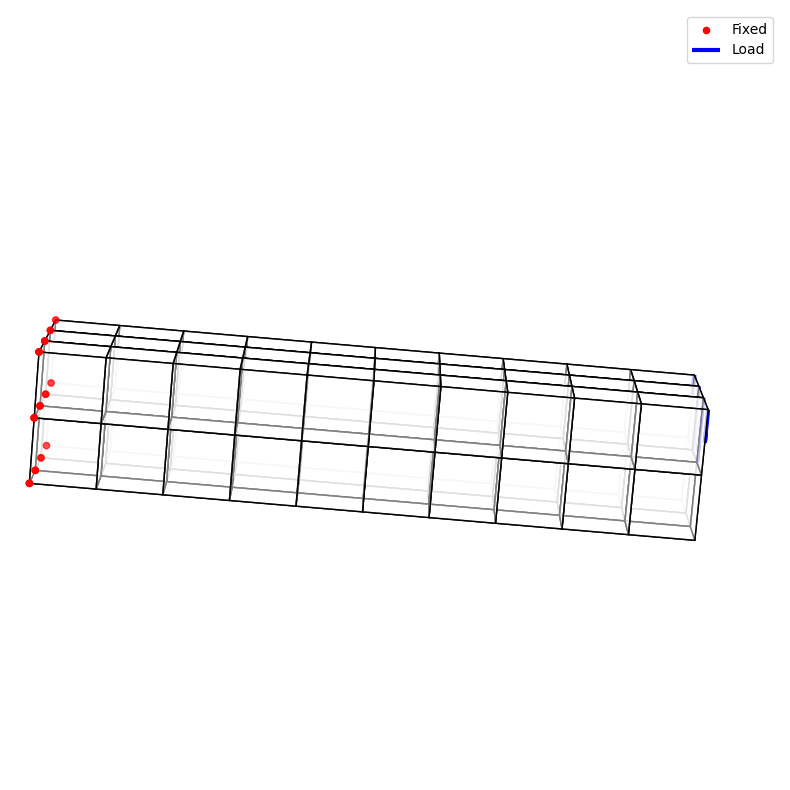

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 三次元要素の各面を構成する要素節点番号
face_nodes = np.array(
    [
        [0, 1, 2, 3],
        [4, 5, 1, 0],
        [1, 5, 6, 2],
        [6, 7, 3, 2],
        [4, 0, 3, 7],
        [5, 4, 7, 6],
    ]
)

# 全要素の面を構成する全体節点番号
face_points = np.asarray(connectivity)[:, face_nodes]
# 全要素の面を構成する座標
face_coords = coords[face_points]

# 描画設定
kwargs = {
    "edgecolor": "k",
    "lw": 1,
    "cmap": "rainbow",
    "facecolors": "w",
    "alpha": 0.5,
    "facecolor": "w",
}

# メッシュの描画
vertices = face_coords.reshape(-1, 4, 3)
pcm = Poly3DCollection(vertices, **kwargs)
ax.add_collection3d(pcm)

# 固定点の描画
fix_pts = [ipnt for ipnt, _ in fix_points]
ax.scatter3D(
    coords[fix_pts, 0],
    coords[fix_pts, 1],
    coords[fix_pts, 2],
    color="r",
    s=20,
    label="Fixed",
)

# 荷重の描画
loads = np.zeros_like(coords)
load_pts = []
for ipnt, idof, force in applied_forces:
    # at.[:, :].set(v)の形に変更
    loads = loads.at[ipnt, idof].set(force)
    load_pts.append(ipnt)
loads /= np.max(np.abs(loads)) / max(width / nx, height / ny, depth / nz)

ax.quiver(
    coords[load_pts, 0],
    coords[load_pts, 1],
    coords[load_pts, 2],
    loads[load_pts, 0],
    loads[load_pts, 1],
    loads[load_pts, 2],
    linewidth=3,
    color="b",
    label="Load",
)

# プロット設定
ax.set_xlim([0, width * 1.1])
ax.set_ylim([0, depth * 1.1])
ax.set_zlim([0, height * 1.1])
# ax.set_box_aspect((width, depth, height))
ax.set_aspect("equal")
ax.view_init(elev=100, azim=-85)
ax.legend()
ax.axis("off")
plt.tight_layout()
plt.savefig("mesh_3d_jax.png", dpi=300, transparent=True)

## 2. 形状関数の実装

自然座標系での積分点座標（問2. 三次元解析編 再掲）

In [ ]:
# 一次元での積分点座標
gauss_points_1d = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
# 一次元での積分点を並べて三次元上に配置する
r1, r2, r3 = np.meshgrid(gauss_points_1d, gauss_points_1d, gauss_points_1d)
# 三次元での積分点座標
gauss_points_3d = np.vstack([r1.flatten(), r2.flatten(), r3.flatten()]).T
# 各積分点での重み
weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

形状関数の取得
$$
N^1(r_1,r_2,r_3)=\frac{1}{8}(1-r_1)(1-r_2)(1-r_3) \\
N^2(r_1,r_2,r_3)=\frac{1}{8}(1+r_1)(1-r_2)(1-r_3) \\
N^3(r_1,r_2,r_3)=\frac{1}{8}(1+r_1)(1+r_2)(1-r_3) \\
N^4(r_1,r_2,r_3)=\frac{1}{8}(1-r_1)(1+r_2)(1-r_3) \\
N^5(r_1,r_2,r_3)=\frac{1}{8}(1-r_1)(1-r_2)(1+r_3) \\
N^6(r_1,r_2,r_3)=\frac{1}{8}(1+r_1)(1-r_2)(1+r_3) \\
N^7(r_1,r_2,r_3)=\frac{1}{8}(1+r_1)(1+r_2)(1+r_3) \\
N^8(r_1,r_2,r_3)=\frac{1}{8}(1-r_1)(1+r_2)(1+r_3)
$$

In [ ]:
@jit
def get_shape_func(rcods: np.ndarray) -> np.ndarray:
    """座標から対応する形状関数Nを取得する"""
    r1, r2, r3 = rcods[..., 0], rcods[..., 1], rcods[..., 2]
    N = np.array(
        [
            0.125 * (1 - r1) * (1 - r2) * (1 - r3),  # N1
            0.125 * (1 + r1) * (1 - r2) * (1 - r3),  # N2
            0.125 * (1 + r1) * (1 + r2) * (1 - r3),  # N3
            0.125 * (1 - r1) * (1 + r2) * (1 - r3),  # N4
            0.125 * (1 - r1) * (1 - r2) * (1 + r3),  # N5
            0.125 * (1 + r1) * (1 - r2) * (1 + r3),  # N6
            0.125 * (1 + r1) * (1 + r2) * (1 + r3),  # N7
            0.125 * (1 - r1) * (1 + r2) * (1 + r3),  # N8
        ]
    ).T
    return N

自然座標系におけるBマトリックスの取得
$$
B^1_1(r_1,r_2,r_3) = \frac{\partial N^1(r_1,r_2,r_3)}{\partial r_1}=-\frac{1}{8}(1-r_2)(1-r_3) \\
B^1_2(r_1,r_2,r_3) = \frac{\partial N^1(r_1,r_2,r_3)}{\partial r_2}=-\frac{1}{8}(1-r_1)(1-r_3) \\
B^1_3(r_1,r_2,r_3) = \frac{\partial N^1(r_1,r_2,r_3)}{\partial r_3}=-\frac{1}{8}(1-r_1)(1-r_2) \\ \vdots \\ B^8_1(r_1,r_2,r_3) = \frac{\partial N^8(r_1,r_2,r_3)}{\partial r_1}=-\frac{1}{8}(1+r_2)(1+r_3) \\
B^8_2(r_1,r_2,r_3) = \frac{\partial N^8(r_1,r_2,r_3)}{\partial r_2}=\frac{1}{8}(1-r_1)(1+r_3) \\
B^8_3(r_1,r_2,r_3) = \frac{\partial N^8(r_1,r_2,r_3)}{\partial r_3}=\frac{1}{8}(1-r_1)(1+r_2)
$$

In [ ]:
@jit
def get_bmat_natural(rcods: np.ndarray) -> np.ndarray:
    """座標から自然座標系でのBマトリックスを返す"""
    r1, r2, r3 = rcods[..., 0], rcods[..., 1], rcods[..., 2]
    # BI1 = ∂NI/∂r1 (:, 8)
    B1 = np.array(
        [
            -0.125 * (1 - r2) * (1 - r3),  # B11
            0.125 * (1 - r2) * (1 - r3),  # B21
            0.125 * (1 + r2) * (1 - r3),  # B31
            -0.125 * (1 + r2) * (1 - r3),  # B41
            -0.125 * (1 - r2) * (1 + r3),  # B51
            0.125 * (1 - r2) * (1 + r3),  # B61
            0.125 * (1 + r2) * (1 + r3),  # B71
            -0.125 * (1 + r2) * (1 + r3),  # B81
        ]
    ).T
    # BI2 = ∂NI/∂r2 (:, 8)
    B2 = np.array(
        [
            -0.125 * (1 - r1) * (1 - r3),  # B12
            -0.125 * (1 + r1) * (1 - r3),  # B22
            0.125 * (1 + r1) * (1 - r3),  # B32
            0.125 * (1 - r1) * (1 - r3),  # B42
            -0.125 * (1 - r1) * (1 + r3),  # B52
            -0.125 * (1 + r1) * (1 + r3),  # B62
            0.125 * (1 + r1) * (1 + r3),  # B72
            0.125 * (1 - r1) * (1 + r3),  # B82
        ]
    ).T
    # BI3 = ∂NI/∂r3 (:, 8)
    B3 = np.array(
        [
            -0.125 * (1 - r1) * (1 - r2),  # B13
            -0.125 * (1 + r1) * (1 - r2),  # B23
            -0.125 * (1 + r1) * (1 + r2),  # B33
            -0.125 * (1 - r1) * (1 + r2),  # B43
            0.125 * (1 - r1) * (1 - r2),  # B53
            0.125 * (1 + r1) * (1 - r2),  # B63
            0.125 * (1 + r1) * (1 + r2),  # B73
            0.125 * (1 - r1) * (1 + r2),  # B83
        ]
    ).T
    return np.stack((B1, B2, B3), axis=-1)  # (:, 8, 3)

In [ ]:
# 積分点座標から自然座標系でのBマトリックスを作成
bmat_nat = get_bmat_natural(gauss_points_3d)

全体座標系におけるBマトリックスと重みの取得
$$
B^I_i
= \frac{\partial N^I}{\partial x_i}
= \frac{\partial N^I}{\partial r_j}  \frac{\partial r_j}{\partial x_i}
= B^I_{\mathrm{nat}\ j}\ J_{ji}^{-1}
$$

In [ ]:
@jit
def get_bmatrix(ncods: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """全体座標から全体座標系でのBマトリックスと重み×ヤコビ行列式を取得する"""
    # ヤコビ行列 Jij = BnatIj * xIi
    jacob = np.einsum("gIj,...Ii->...gij", bmat_nat, ncods)
    # ヤコビ行列指揮 detJ
    detJ = np.sqrt(np.linalg.det(np.einsum("...gki,...gkj->...gij", jacob, jacob)))
    # J^-1ji
    jinv = np.linalg.inv(jacob)
    # 全体座標系でのBマトリックス BIi = BnatIj * J^-1ji
    bmat_phys = np.einsum("gIj,...gji->...gIi", bmat_nat, jinv)
    # 重み×ヤコビ行列式 w * detJ
    wdetJ = weights * detJ
    # 全体座標系でのBマトリックスと重み×ヤコビ行列式を返す
    return bmat_phys, wdetJ

## 3. 支配方程式の実装

弾性係数の実装（問2. 三次元解析編 再掲）
$$
[C] = \begin{bmatrix} \lambda + 2\mu & \lambda & \lambda & 0 & 0 & 0 \\ \lambda & \lambda + 2\mu & \lambda & 0 & 0 & 0 \\ \lambda & \lambda & \lambda + 2\mu & 0 & 0 & 0 \\ 0 & 0 & 0 & \mu & 0 & 0 \\ 0 & 0 & 0 & 0 & \mu & 0 \\ 0 & 0 & 0 & 0 & 0 & \mu \end{bmatrix}
$$

In [ ]:
# 鋼材を想定
# ヤング率 E
YOUNG = 205e9
# ポアソン比 ν
POISSON = 0.27
# λ = Eν/((1+ν)(1-2ν))
c_lambda = YOUNG * POISSON / ((1.0 + POISSON) * (1.0 - 2.0 * POISSON))
# μ = E/(2*(1+ν))
c_mu = YOUNG / (2.0 * (1.0 + POISSON))
# 弾性係数行列 C
Cmatrix = np.array(
    [
        [c_lambda + 2 * c_mu, c_lambda, c_lambda, 0, 0, 0],
        [c_lambda, c_lambda + 2 * c_mu, c_lambda, 0, 0, 0],
        [c_lambda, c_lambda, c_lambda + 2 * c_mu, 0, 0, 0],
        [0, 0, 0, c_mu, 0, 0],
        [0, 0, 0, 0, c_mu, 0],
        [0, 0, 0, 0, 0, c_mu],
    ]
)

全体剛性行列の初期化（問2. 三次元解析編 再掲）

In [ ]:
# 全体剛性 (全自由度数 = 次元(n_dof) * 全節点数(n_point))
Kmatrix = np.zeros((n_dof * n_point, n_dof * n_point))
Fvector = np.zeros(n_dof * n_point)
# Bマトリックスの行数 (変形に関する自由度)
# n_dfdof = 3  # 二次元解析
n_dfdof = 6  # 三次元解析
# 要素を構成する節点数(今回はすべて六面体一次)
n_node = 8
# 要素内の積分点数(今回はすべて積分次数2)
n_intgp = 8  # 8=2^3
# バッチサイズ(同時に計算する要素数)
batch_size = 7

変位$u$の初期化（今後の増分解法を見越した実装）

In [ ]:
# 変位
displacements = np.zeros((n_point, n_dof))

内力$Q^{\mathrm{e}}$の計算
$$
\left\{ Q^{\mathrm{e}} \right\} = \sum_{I_{\mathrm{g}}=1}^{N_{\mathrm{g}}}[B]^{\mathrm{T}} \{ \sigma \} \ w_{I_{\mathrm{g}}} \det \boldsymbol{J}  = \sum_{I_{\mathrm{g}}=1}^{N_{\mathrm{g}}}[B]^{\mathrm{T}} [C] [B] \{ u \} \ w_{I_{\mathrm{g}}} \det \boldsymbol{J}
\\
Q^{\mathrm{e}}_i =B_{gji}\sigma_{j} (w\det J)_{g} = B_{gji}C_{jk}B_{gkl}u_{\ l} (w\det J)_{g}
$$

In [ ]:
def calc_internal_force(
    ue: np.ndarray, Bd: np.ndarray, wdetJ: np.ndarray
) -> np.ndarray:
    """内力Qの計算"""
    Qe = np.einsum("gji, jk, gkl, l, g -> i", Bd, Cmatrix, Bd, ue, wdetJ)
    return Qe

自動微分による要素剛性行列$K^{\mathrm{e}}_{ij}$の計算
$$
\left[ K^{\mathrm{e}}_{ij} \right] = \frac{ \partial \left\{ Q^{\mathrm{e}}_i \right\} }{\partial \left\{ u_j\right\} }
$$

In [ ]:
def calc_element_stiffness(
    ue: np.ndarray, Bd: np.ndarray, wdetJ: np.ndarray
) -> np.ndarray:
    """要素剛性行列ke=∂Q/∂uを自動微分により計算"""
    # ke = jax.jacrev(calc_internal_force, argnums=0)(ue, Bd, wdetJ)  # reverse mode
    ke = jax.jacfwd(calc_internal_force, argnums=0)(ue, Bd, wdetJ)  # forward mode
    return ke

要素剛性行列の計算・全体剛性行列への足し込み

In [ ]:
# バッチサイズ分一気に計算
for idx in range(0, n_element, batch_size):
    # 同時に計算する要素番号
    batch = np.asarray(list(range(idx, min(idx + batch_size, n_element))))
    # 要素を構成する節点番号
    elm_nodes = np.asarray(connectivity)[batch]
    # 要素の節点座標
    elm_cods = coords[elm_nodes]

    # Bマトリックスと重み*ヤコビアンの取得
    Bmatrix, wdetJv = get_bmatrix(elm_cods)
    # 行列[B]の作成（代入方法変更）
    Bd = np.zeros((len(batch), n_intgp, n_dfdof, n_dof * n_node))
    Bd = Bd.at[..., 0, ::n_dof].set(Bmatrix[..., 0])
    Bd = Bd.at[..., 3, ::n_dof].set(Bmatrix[..., 1])
    Bd = Bd.at[..., 5, ::n_dof].set(Bmatrix[..., 2])
    Bd = Bd.at[..., 1, 1::n_dof].set(Bmatrix[..., 1])
    Bd = Bd.at[..., 3, 1::n_dof].set(Bmatrix[..., 0])
    Bd = Bd.at[..., 4, 1::n_dof].set(Bmatrix[..., 2])
    Bd = Bd.at[..., 2, 2::n_dof].set(Bmatrix[..., 2])
    Bd = Bd.at[..., 4, 2::n_dof].set(Bmatrix[..., 1])
    Bd = Bd.at[..., 5, 2::n_dof].set(Bmatrix[..., 0])

    # 要素における変位
    elm_disp = displacements[elm_nodes]
    ue_flat = elm_disp.reshape(len(batch), n_dof * n_node)

    # 自動微分による要素剛性行列の計算
    element_stiffness_vmap = jax.jit(
        jax.vmap(calc_element_stiffness, in_axes=(0, 0, 0))
    )
    ke = element_stiffness_vmap(ue_flat, Bd, wdetJv)

    # 要素剛性行列を陽に計算する方法と比較
    ke_explicit = np.einsum(
        "...gki, kl, ...glj, ...g -> ...ij", Bd, Cmatrix, Bd, wdetJv
    )
    # 差を計算
    ke_diff = ke - ke_explicit
    max_diff = np.max(np.abs(ke_diff))
    print(
        f"batch[{idx + 1}] 最大差分: {max_diff}, max(ke): {np.max(np.abs(ke))} ({max_diff/np.max(np.abs(ke)):.3e}), max(ke_explicit): {np.max(np.abs(ke_explicit))} ({max_diff/np.max(np.abs(ke_explicit)):.3e})"
    )

    # 全体剛性行列への足し込み K <- Ke
    for i, ielm in enumerate(batch):
        for inod in range(n_node):
            for jnod in range(n_node):
                for idof in range(n_dof):
                    for jdof in range(n_dof):
                        ipnt = connectivity[ielm][inod]
                        jpnt = connectivity[ielm][jnod]
                        # (記法変更)
                        Kmatrix = Kmatrix.at[
                            n_dof * ipnt + idof, n_dof * jpnt + jdof
                        ].add(ke[i, n_dof * inod + idof, n_dof * jnod + jdof])

batch[1] 最大差分: 64.0, max(ke): 463977536.0 (1.379e-07), max(ke_explicit): 463977536.0 (1.379e-07)
batch[8] 最大差分: 64.0, max(ke): 463977472.0 (1.379e-07), max(ke_explicit): 463977504.0 (1.379e-07)
batch[15] 最大差分: 64.0, max(ke): 463977536.0 (1.379e-07), max(ke_explicit): 463977536.0 (1.379e-07)
batch[22] 最大差分: 64.0, max(ke): 463977536.0 (1.379e-07), max(ke_explicit): 463977536.0 (1.379e-07)
batch[29] 最大差分: 64.0, max(ke): 463977472.0 (1.379e-07), max(ke_explicit): 463977472.0 (1.379e-07)
batch[36] 最大差分: 64.0, max(ke): 463977536.0 (1.379e-07), max(ke_explicit): 463977536.0 (1.379e-07)
batch[43] 最大差分: 96.0, max(ke): 463977600.0 (2.069e-07), max(ke_explicit): 463977600.0 (2.069e-07)
batch[50] 最大差分: 64.0, max(ke): 463977440.0 (1.379e-07), max(ke_explicit): 463977440.0 (1.379e-07)
batch[57] 最大差分: 64.0, max(ke): 463977536.0 (1.379e-07), max(ke_explicit): 463977536.0 (1.379e-07)


## 4. 境界条件の適用

境界条件（荷重）

In [ ]:
# 境界条件(荷重)
for ipnt, idof, force in applied_forces:
    # 荷重が加わる全体自由度番号
    idx = n_dof * ipnt + idof
    # 右辺外力ベクトルに荷重を加える（記法変更）
    Fvector = Fvector.at[idx].add(force)

境界条件（固定端）

In [ ]:
# ペナルティー係数*全体剛性行列成分の最大値
penalty = 1.0e8 * np.max(np.abs(Kmatrix))
for ipnt, idof in fix_points:
    # 固定点の全体自由度番号
    idx = n_dof * ipnt + idof
    # 全体剛性行列の対角成分にペナルティーを加える（記法変更）
    Kmatrix = Kmatrix.at[idx, idx].add(penalty)

## 5. 剛性方程式の求解

全体剛性方程式$[K]\{U\}=\{F\}$を解く

In [ ]:
from jax.experimental.sparse import csr_fromdense
from jax.experimental.sparse.linalg import spsolve

In [ ]:
# JAXにもspsolveは存在するが仕様が異なる
sparse_Kmatrix = csr_fromdense(Kmatrix)

# CSR の各コンポーネントを取得
data = sparse_Kmatrix.data
indices = sparse_Kmatrix.indices
indptr = sparse_Kmatrix.indptr

# 線形方程式を解く
Uvector = spsolve(data, indices, indptr, Fvector)

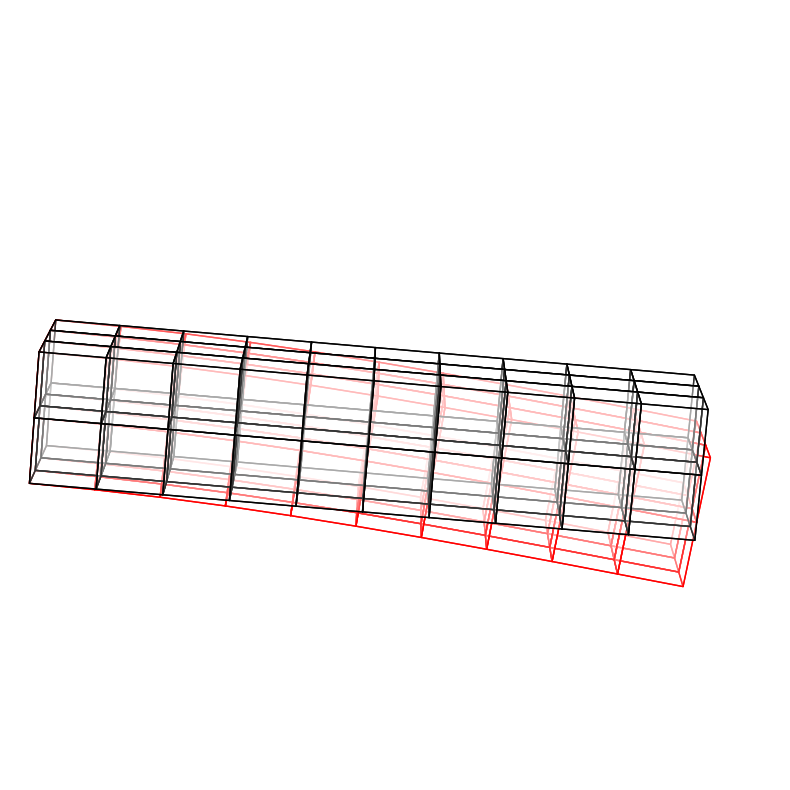

In [ ]:
# 変位を1000倍にしてプロット
displacement = Uvector.reshape(n_point, n_dof)
deformed_coords = coords + 100 * displacement

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 変形前のメッシュを黒，変形後のメッシュを赤色でプロット
for cod, c in zip((coords, deformed_coords), ("black", "red")):
    # 全要素の面を構成する全体節点番号
    face_points = np.asarray(connectivity)[:, face_nodes]
    # 全要素の面を構成する座標
    face_coords = cod[face_points]

    # 描画設定
    kwargs = {
        "edgecolor": c,
        "lw": 1,
        "cmap": "rainbow",
        "facecolors": "w",
        "alpha": 0.2,
        "facecolor": "w",
    }

    # メッシュ描画
    vertices = face_coords.reshape(-1, 4, 3)
    pcm = Poly3DCollection(vertices, **kwargs)
    ax.add_collection3d(pcm)

# プロット設定
ax.set_xlim([0, width * 1.1])
ax.set_ylim([0, depth * 1.1])
ax.set_zlim([0, height * 1.1])
# ax.set_box_aspect((width, depth, height))
ax.set_aspect("equal")
ax.view_init(elev=100, azim=-85)
ax.axis("off")
plt.tight_layout()
plt.savefig("result_3d_jax.png", dpi=300, transparent=True)

以上